<a href="https://colab.research.google.com/github/kpetridis24/computational-intelligence/blob/main/digit_recognition_mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Digit Recognition with MLP Neural Network

In [7]:
!pip install -q -U keras-tuner
!sudo apt install cm-super &> /dev/null
!pip install latex &> /dev/null
!sudo apt install texlive texlive-latex-extra texlive-fonts-recommended dvipng &> /dev/null

Import useful modules

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
device_name = tf.test.gpu_device_name()
import keras_tuner as kt

Load the dataset

In [2]:
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

Reshape the input data so that it fits in the input layer appropriately

In [3]:
X_train = X_train.reshape(len(X_train), 28 * 28)
X_test = X_test.reshape(len(X_test), 28 * 28)

X_train = X_train / 255
X_test = X_test / 255

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

MLP using **RMSProp** optimizer



In [5]:
histories = {0.01: None, 0.99: None}

for rho in [0.01, 0.99]:
    model = keras.Sequential([
        keras.layers.Dense(126, input_shape=(784,), activation="relu"),
        keras.layers.Dense(256, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(learning_rate=0.001, rho=rho),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    batch_size = 256

    with tf.device('/device:GPU:0'):
        his = model.fit(
            X_train, 
            y_train, 
            epochs=3, 
            batch_size=batch_size, 
            validation_data=(X_val, y_val), 
            verbose=0
        )

        histories[rho] = his

Plot the **Accuracy** and **Loss** of the model

In [ ]:
plt.rcParams['text.usetex'] = True

for rho, his in histories.items():
    # Accuracy plot
    plt.plot(his.history["accuracy"])
    plt.plot(his.history["val_accuracy"])
    plt.title(f'RMSRop, $lr=0.001, \\rho={rho}$')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()

    # Cost plot
    plt.plot(his.history["loss"])
    plt.plot(his.history["val_loss"])
    plt.title(f'RMSRop, $lr=0.001, \\rho={rho}$')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'])
    plt.show()

Use **L1 and L2 Regularization**

In [17]:
histories = {
    0.01: {
        "L1": {
            0.1: None,
            0.01: None,
            0.001: None
        },
        "L2": {
            0.1: None,
            0.01: None,
            0.001: None
        },
    },
    0.99: {
        "L1": {
            0.1: None,
            0.01: None,
            0.001: None
        },
        "L2": {
            0.1: None,
            0.01: None,
            0.001: None
        },
    }
}

with tf.device('/device:GPU:0'):
    for rho in [0.01, 0.99]:
        for alpha in [0.1, 0.01, 0.001]:
            for regularizer in [
                keras.regularizers.L1(alpha), 
                keras.regularizers.L2(alpha)
            ]:
                model = keras.Sequential([
                    keras.layers.Dense(
                        126, 
                        input_shape=(784,), 
                        activation="relu", 
                        kernel_regularizer=regularizer
                    ),
                    keras.layers.Dense(
                        256, 
                        activation="relu", 
                        kernel_regularizer=regularizer
                    ),
                    keras.layers.Dense(
                        10, 
                        activation="softmax", 
                        kernel_regularizer=regularizer
                    ),
                ])

                model.compile(
                    optimizer=keras.optimizers.RMSprop(learning_rate=0.001, rho=rho),
                    loss="sparse_categorical_crossentropy",
                    metrics=["accuracy"]
                )

                his = model.fit(
                    X_train, 
                    y_train, 
                    epochs=3, 
                    batch_size=256, 
                    validation_data=(X_val, y_val), 
                    verbose=0
                )

                reg = str(regularizer).split(".")[2].split(" ")[0]
                histories[rho][reg][alpha] = his

Plot **Accuracy** and **Loss** for all parameters (L1, L2, $\alpha, \rho$)

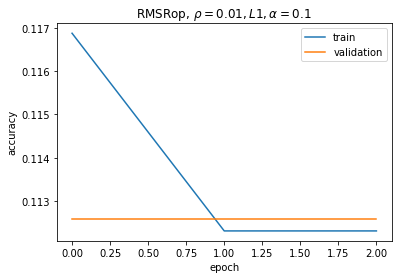

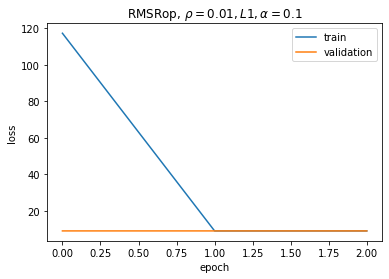

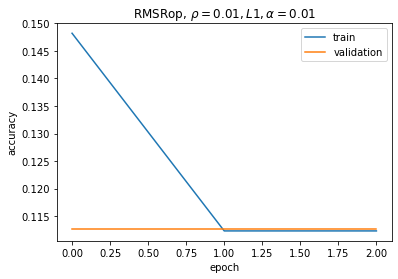

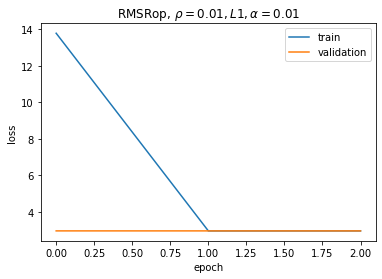

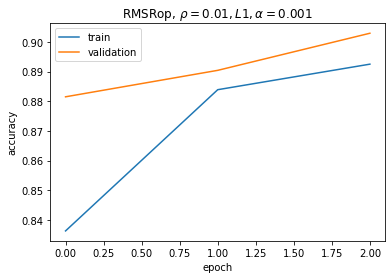

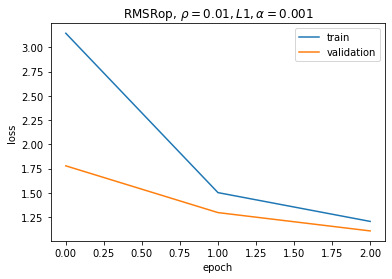

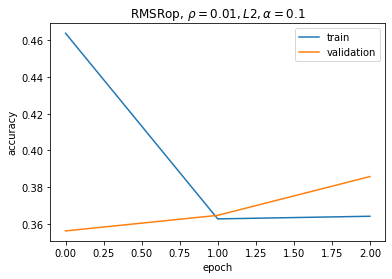

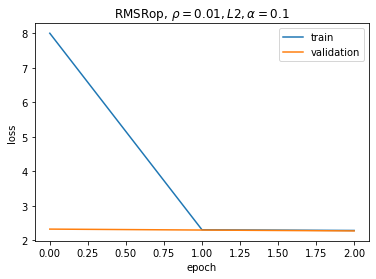

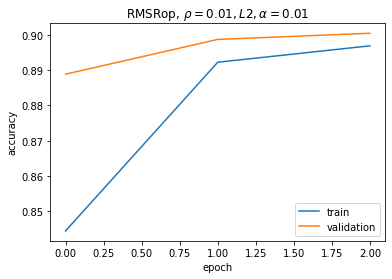

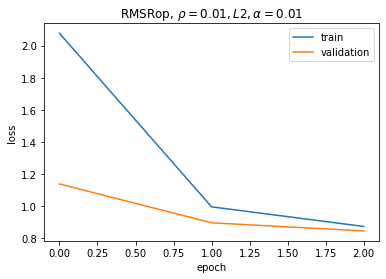

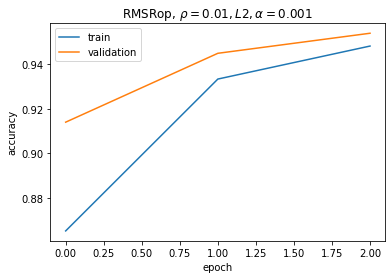

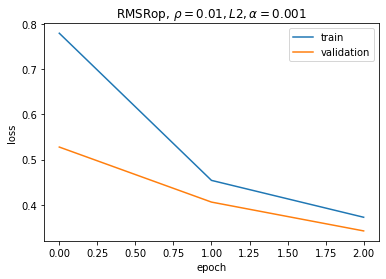

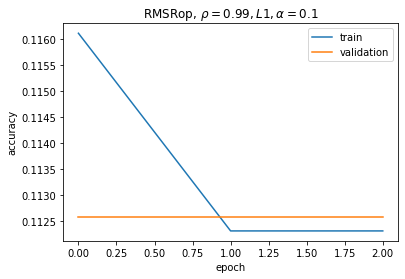

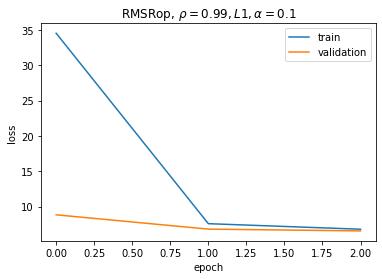

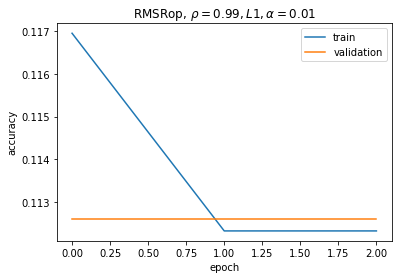

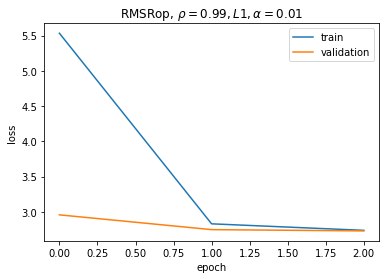

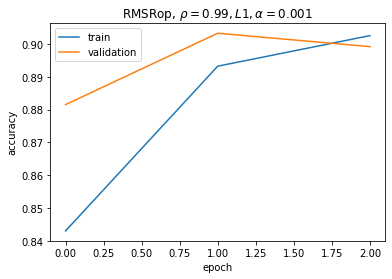

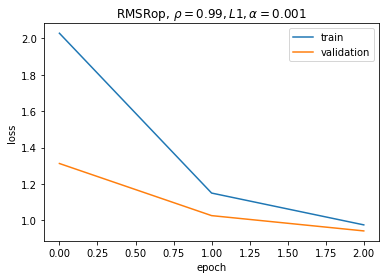

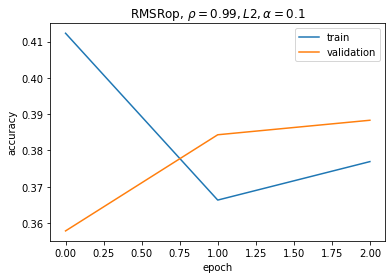

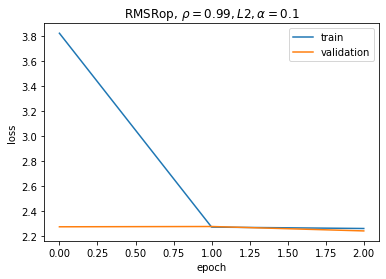

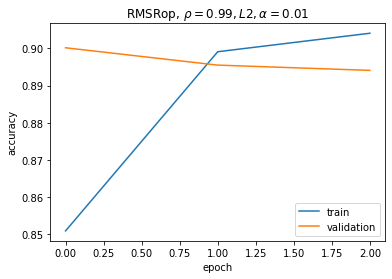

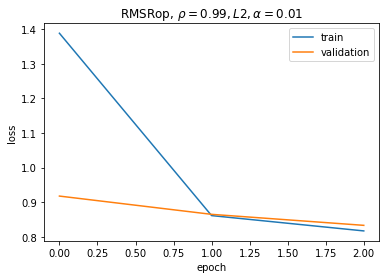

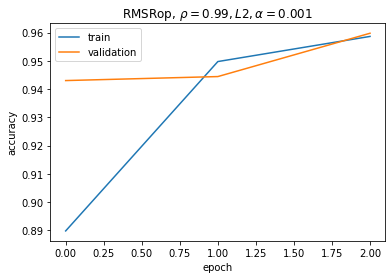

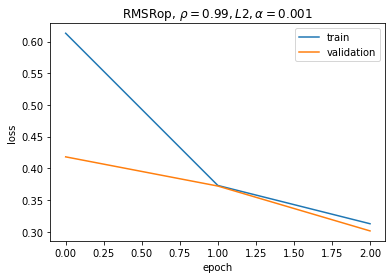

In [18]:
for rho, params in histories.items():
    for regularizer, data in params.items():
        for alpha, his in data.items():
            # Accuracy plot
            plt.plot(his.history["accuracy"])
            plt.plot(his.history["val_accuracy"])
            plt.title(f'RMSRop, $\\rho={rho}, {regularizer}, \\alpha={alpha}$')
            plt.ylabel('accuracy')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'])
            plt.show()

            # Cost plot
            plt.plot(his.history["loss"])
            plt.plot(his.history["val_loss"])
            plt.title(f'RMSRop, $\\rho={rho}, {regularizer}, \\alpha={alpha}$')
            plt.ylabel('loss')
            plt.xlabel('epoch')
            plt.legend(['train', 'validation'])
            plt.show()

**Fine Tuning** using Keras Tuner

In [20]:
def build_model(hp):
    hp_units1 = hp.Choice('units1', values=[64, 128])
    hp_units2 = hp.Choice('units2', values=[256, 512])
    hp_learning_rate = hp.Choice('learning rate', values=[1e-1, 1e-2, 1e-3])
    hp_a = hp.Choice('coef', values=[1e-1, 1e-3, 1e-6])

    model = keras.Sequential([
        keras.layers.Dense(
            hp_units1, 
            input_shape=(784,), 
            activation="relu", 
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=keras.regularizers.L2(hp_a)
        ),
        keras.layers.Dense(
            hp_units2, 
            activation="relu", 
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=keras.regularizers.L2(hp_a)
        ),
        keras.layers.Dense(
            10, 
            activation="softmax", 
            kernel_initializer=tf.keras.initializers.HeNormal(),
            kernel_regularizer=keras.regularizers.L2(hp_a)
        ),
    ])

    model.compile(
        optimizer=keras.optimizers.RMSprop(
            learning_rate=hp_learning_rate, 
            rho=0.9
        ),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    return model

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_loss',
    max_trials=20,
    overwrite=True
)

stop_early = keras.callbacks.EarlyStopping(monitor='loss', patience=200)

tuner.search(
    X_train, 
    y_train, 
    epochs=100, 
    validation_data=(X_val, y_val), 
    callbacks=[stop_early]
)

Trial 3 Complete [00h 09m 20s]
val_loss: 2.2192740440368652

Best val_loss So Far: 0.10572252422571182
Total elapsed time: 00h 26m 42s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
64                |64                |units1
256               |256               |units2
0.001             |0.001             |learning rate
1e-06             |1e-06             |coef

Epoch 1/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2701 - accuracy: 0.9194 - val_loss: 0.1447 - val_accuracy: 0.9560
Epoch 2/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.1284 - accuracy: 0.9620 - val_loss: 0.1244 - val_accuracy: 0.9622
Epoch 3/100
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0937 - accuracy: 0.9716 - val_loss: 0.1052 - val_accuracy: 0.9722
Epoch 4/100
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0781 - accuracy: 0.9764 - val_loss: 0.1048 - val_accuracy: 0.9728
Epoch 5/100
1500/15

Get the best RBF model

In [ ]:
best_model = tuner.get_best_models()[0]
best_hs = tuner.get_best_hyperparameters()[0]
best_model.summary()

n1_optimal = best_hs.get("units_1")
n2_optimal = best_hs.get("units_2")
alpha_optimal = best_hs.get("a_reg")
lr_optimal = best_hs.get("learning_rate")

Train and analyze the best model

In [ ]:
regularizer = tf.keras.regularizers.l2(alpha_optimal)
optimizer = keras.optimizers.RMSprop(learning_rate=lr_optimal)

optimal_model = keras.Sequential([
    keras.layers.Dense(
        n1_optimal, 
        input_shape=(784,), 
        activation="relu", 
        kernel_regularizer=regularizer, 
        kernel_initializer=tf.keras.initializers.HeNormal()
    ),
    keras.layers.Dense(
        n2_optimal,
        activation="relu"
    ),
    keras.layers.Dense(
        10, 
        activation="softmax"
    )
])

model.compile(
    optimizer=optimizer,
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = optimal_model.fit(
    X_train, 
    y_train, 
    batch_size=256, 
    epochs=100, 
    validation_data=(X_test, y_test)
)

In [ ]:
y_predictions = optimal_model.predict(X_test)
y_pred_labels = [np.argmax(pred) for pred in y_predictions]
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred_labels)

plt.figure(figsize=(10, 7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel("Predicted")
plt.ylabel("True")